In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem

import mordred
from mordred import Calculator, descriptors

import pandas as pd
from tqdm import tqdm


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


The dataset loading

In [2]:
df = pd.read_excel('HILIC_dataset.xlsx', skiprows=2, usecols= [0,1,2])
df.head(4)

,NAME,SMILES,Experimental Retention Time
0,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid",C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,2.019083
1,"1,1-Dimethyl-4-phenylpiperazinium",CC1C(NC(CN1)C2=CC=CC=C2)C,2.607950
2,"1,2-Cyclohexanediol",C1CCC(C(C1)O)O,4.876550
3,"1,2-Cyclohexanedione",C1CCC(=O)C(=O)C1,5.772267


3D+2D Descriptors loading


In [3]:
mol_list = []

for smile in df['SMILES']:
  mol = Chem.MolFromSmiles(smile)
  mol = Chem.AddHs(mol)
  mol_list.append(mol)
df = pd.concat([df, pd.DataFrame(mol_list, columns = (['Mol']))], axis=1)

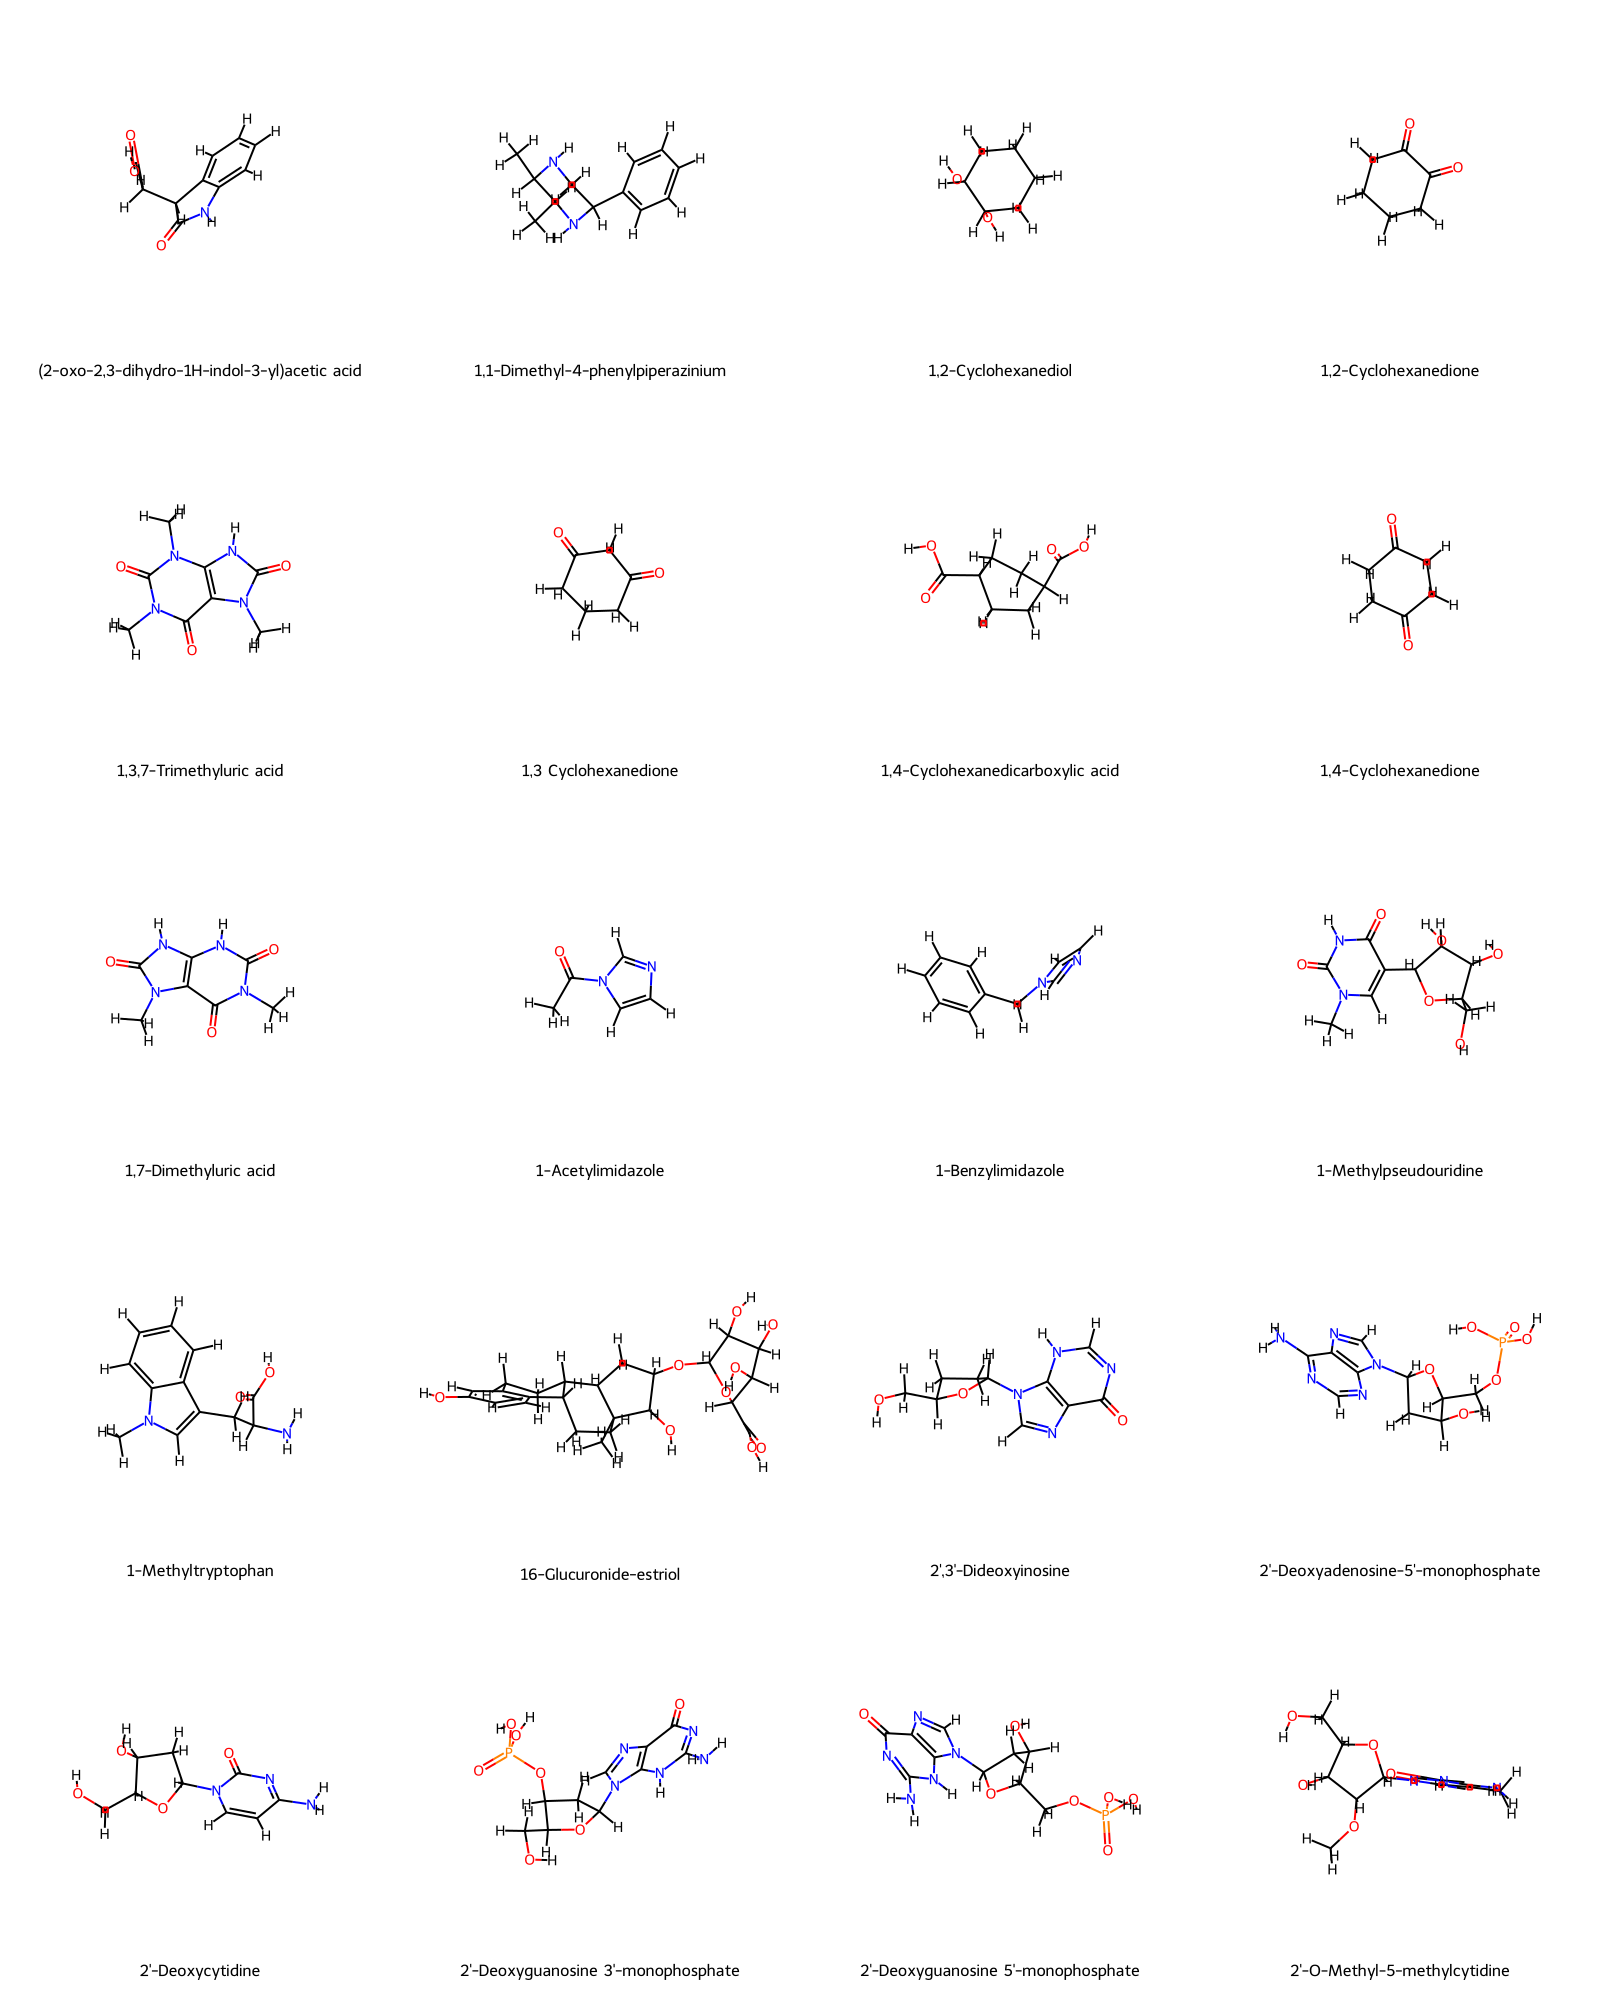

In [7]:
Draw.MolsToGridImage(df['Mol'][:20],molsPerRow=4,subImgSize=(400,400),legends=[x for x in df['NAME'][:20]])

In [5]:
calc = Calculator(descriptors, ignore_3D=False)
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)
d = []
for mol in tqdm(df['Mol']):
  generate_3d_coordinates(mol)

 # Calculate descriptors
  result = calc(mol)
  d.append(result)


final_df = pd.concat([df[['NAME', 'SMILES']], pd.DataFrame(d, columns = (str(key) for key in result.keys()))], axis=1)
     

 13%|█▎        | 133/1023 [00:14<02:03,  7.19it/s]c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 1023/1023 [02:42<00:00,  6.31it/s]


In [6]:
final_df.drop(['ABC', 'ABCGG'], axis=1, inplace=True)
final_df.head(4)


,NAME,SMILES,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,"(2-oxo-2,3-dihydro-1H-indol-3-yl)acetic acid",C1=CC=C2C(=C1)C(C(=O)N2)CC(=O)O,1,0,17.506132,2.443585,4.706389,17.506132,1.250438,3.573622,...,9.497097,60.030351,191.058243,8.306880,287,19,72.0,84.0,5.055556,3.083333
1,"1,1-Dimethyl-4-phenylpiperazinium",CC1C(NC(CN1)C2=CC=CC=C2)C,0,2,18.348875,2.335372,4.670745,18.348875,1.310634,3.564716,...,9.398561,45.522055,190.146999,5.942094,303,19,70.0,80.0,4.444444,3.138889
2,"1,2-Cyclohexanediol",C1CCC(C(C1)O)O,0,0,9.953960,2.193527,4.387054,9.953960,1.244245,2.980241,...,8.555837,35.908899,116.083730,5.804186,60,8,36.0,39.0,3.222222,1.861111
3,"1,2-Cyclohexanedione",C1CCC(=O)C(=O)C1,0,0,9.953960,2.193527,4.387054,9.953960,1.244245,2.980241,...,8.555837,35.908899,112.052429,7.003277,60,8,36.0,39.0,3.222222,1.861111


The behavior of the 3D descriptors

In [8]:
calc_2d = Calculator(descriptors, ignore_3D=True)
df_2d = calc_2d.pandas(mol_list, quiet=True)  # mols - список ваших молекул

# Извлечение 3D-дескрипторов
columns_3d = final_df.columns.difference(df_2d.columns)
df_3d = final_df[columns_3d]

c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\usser\miniconda3\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
df_3d.head()

,DPSA1,DPSA2,DPSA3,DPSA4,DPSA5,FNSA1,FNSA2,FNSA3,FNSA4,FNSA5,...,WNSA1,WNSA2,WNSA3,WNSA4,WNSA5,WPSA1,WPSA2,WPSA3,WPSA4,WPSA5
0,20.148778,559.540834,56.449595,24.327862,50.445302,0.471901,-0.736460,-0.102702,-0.032020,-0.081829,...,60.662360,-94.671023,-13.202214,-4.116131,-10.519003,67.886443,105.945087,7.037057,4.606308,7.567506
1,174.386748,413.810573,24.199855,12.931580,25.135837,0.280277,-0.292268,-0.026112,-0.009133,-0.029227,...,44.136997,-46.025299,-4.112075,-1.438291,-4.602530,113.339407,118.188379,5.491225,3.693387,5.372199
2,141.062452,259.670225,34.116748,12.983511,24.658866,0.247104,-0.230071,-0.071295,-0.011504,-0.038345,...,19.220125,-17.895330,-5.545412,-0.894767,-2.982555,58.561548,54.525049,3.969533,2.726252,3.894646
3,68.228827,183.208378,33.759310,11.450524,26.709771,0.374734,-0.252094,-0.099622,-0.015756,-0.063024,...,27.792899,-18.697085,-7.388688,-1.168568,-4.674271,46.374074,31.197178,1.805192,1.949824,2.599765
4,138.154841,699.558955,51.082602,27.982358,58.036165,0.313918,-0.591574,-0.080316,-0.023663,-0.084511,...,43.259207,-81.521390,-11.067916,-3.260856,-11.645913,94.545040,178.168846,7.894965,7.126754,9.898269


In [10]:
df_3d.to_excel("3D_descriptors.xlsx", index=False, engine="openpyxl")